In [1]:
# Cell 1: Setup, Drive Mount, and Configuration
from google.colab import drive
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os

# --- 1. MOUNT GOOGLE DRIVE (Critical Step) ---
# force_remount=True is used for reliable connection
drive.mount('/content/drive', force_remount=True)

# **2. DEFINE SAVE PATH**
# Using your new, corrected folder name: L_GTA_model_DATA
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/L_GTA_model_DATA/'

# --- 3. CONFIGURATION ---
TIME_STEPS = 50
DATASET_NAME = "m5_forecasting"
N_FEATURES = 1 # Will be updated to 20 after pivot
# =====================

def create_sequences(data, time_steps):
    """Converts the time series matrix into overlapping fixed-length sequences."""
    X = []
    # Data is already 2D (Time steps x Features)
    for i in range(len(data) - time_steps + 1):
        X.append(data[i:i + time_steps])
    return np.array(X)

print(f"Configuration set: Sequence Length={TIME_STEPS}")
print(f"Save Path set to: {DRIVE_PATH}")

Mounted at /content/drive
Configuration set: Sequence Length=50
Save Path set to: /content/drive/MyDrive/Colab Notebooks/L_GTA_model_DATA/


In [2]:
# Cell 2: File Uploads and Initial Load

print("\nPlease upload the three M5 files now: sales_train_evaluation.csv, calendar.csv, sell_prices.csv")
try:
    # Prompts for file upload (upload all three files at once)
    uploaded = files.upload()

    # Load the three required CSVs
    sales = pd.read_csv("sales_train_evaluation.csv")
    calendar = pd.read_csv("calendar.csv")
    prices = pd.read_csv("sell_prices.csv")

    print("\nFiles uploaded and loaded successfully.")
    print(f"Sales shape: {sales.shape}, Calendar shape: {calendar.shape}, Prices shape: {prices.shape}")

except KeyError as e:
    print(f"❌ ERROR: One or more M5 files not found. Ensure all three files were uploaded. Error: {e}")
    exit()


Please upload the three M5 files now: sales_train_evaluation.csv, calendar.csv, sell_prices.csv


Saving calendar.csv to calendar.csv
Saving sales_train_evaluation.csv to sales_train_evaluation.csv
Saving sell_prices.csv to sell_prices.csv

Files uploaded and loaded successfully.
Sales shape: (30490, 1947), Calendar shape: (1969, 14), Prices shape: (6841121, 4)


In [3]:
# Cell 3: Data Aggregation and Transformation

# 1. Focus on the first 20 time series for a manageable multivariate sample
sales_sample = sales.head(20).copy()

# 2. Melt to long format
sales_long = sales_sample.melt(
    id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
    var_name='d',
    value_name='sales'
)

# 3. Pivot the data to create the Time Steps x Features matrix
# Index='d' (Days/Time Steps), Columns='id' (Items/Features), Values='sales'
sales_matrix_df = sales_long.pivot(index='d', columns='id', values='sales')

# 4. Filter for only the 'd_' columns (Days)
sales_matrix_df = sales_matrix_df[sales_matrix_df.index.str.startswith('d_')]

# Convert to NumPy array
sales_matrix = sales_matrix_df.values
global N_FEATURES
N_FEATURES = sales_matrix.shape[1] # Update the global N_FEATURES variable

print(f"Sales Matrix Shape (Time Steps x Items): {sales_matrix.shape}")
print(f"N_FEATURES set to: {N_FEATURES}")

Sales Matrix Shape (Time Steps x Items): (1941, 20)
N_FEATURES set to: 20


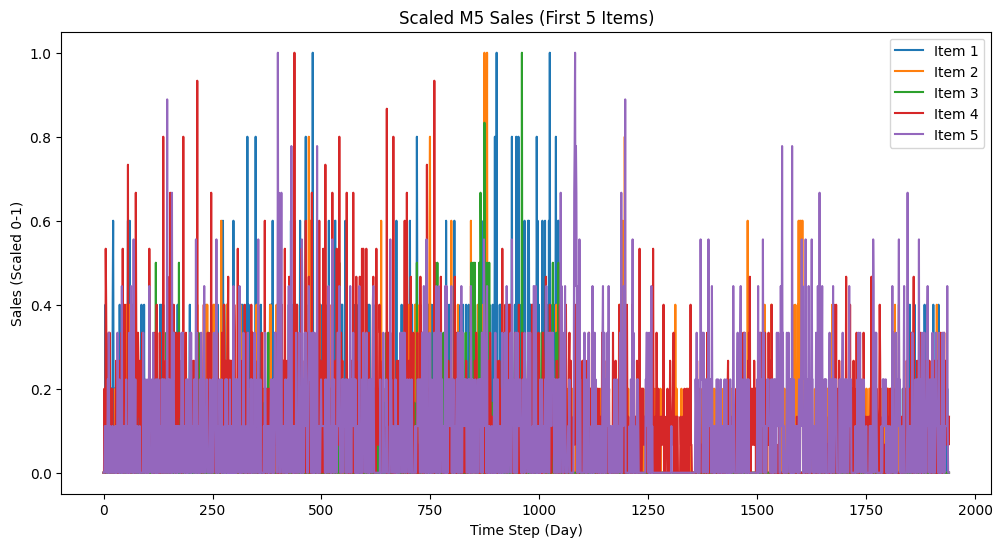

In [4]:
# Cell 4: Scaling and Visualization

# Replace NaNs with 0 (necessary for clean scaling/training)
sales_matrix = np.nan_to_num(sales_matrix, nan=0.0)

# Scale the data (scaling column-wise, i.e., each item's sales history)
scaler_m5 = MinMaxScaler()
m5_scaled = scaler_m5.fit_transform(sales_matrix)

# Visualization (Plotting just the first 5 features)
plt.figure(figsize=(12, 6))
plt.plot(m5_scaled[:, 0:5])
plt.title(f"Scaled M5 Sales (First 5 Items)")
plt.xlabel("Time Step (Day)")
plt.ylabel("Sales (Scaled 0-1)")
plt.legend([f'Item {i+1}' for i in range(5)])
plt.show()

In [7]:
# Cell 5: Sequence Creation, Split, and Final Save

# 1. Create the sequences
X_sequences = create_sequences(m5_scaled, TIME_STEPS)

# 2. Train/Test Split
X_train, X_test = train_test_split(X_sequences, test_size=0.2, random_state=42)

print(f"Final Training Data Shape: {X_train.shape}")
print(f"Final Testing Data Shape: {X_test.shape}")


# 3. GUARANTEE THE DIRECTORY EXISTS
try:
    os.makedirs(DRIVE_PATH, exist_ok=True)
    print(f"\nVerified or created directory: {DRIVE_PATH}")
except Exception as e:
    print(f"CRITICAL ERROR: Directory access failed. Error: {e}")
    exit()


# 2. SAVE THE ARRAYS using the permanent path
np.save(f'{DRIVE_PATH}{DATASET_NAME}_X_train.npy', X_train)
np.save(f'{DRIVE_PATH}{DATASET_NAME}_X_test.npy', X_test)

print(f"\n✅ Data saved successfully and permanently to Drive:")
print(f"   - {DRIVE_PATH}{DATASET_NAME}_X_train.npy") # Correct
print(f"   - {DRIVE_PATH}{DATASET_NAME}_X_test.npy")  # Corrected from DATAET_NAME

Final Training Data Shape: (1513, 50, 20)
Final Testing Data Shape: (379, 50, 20)

Verified or created directory: /content/drive/MyDrive/Colab Notebooks/L_GTA_model_DATA/

✅ Data saved successfully and permanently to Drive:
   - /content/drive/MyDrive/Colab Notebooks/L_GTA_model_DATA/m5_forecasting_X_train.npy
   - /content/drive/MyDrive/Colab Notebooks/L_GTA_model_DATA/m5_forecasting_X_test.npy
